In [1]:
import numpy as np # Math stuff
import pandas as pd # Manipulate data
from numpy import pi
from numpy import tan
from numpy import exp
from numpy import cos
from numpy import sqrt
from scipy.integrate import odeint # Solve DE
import matplotlib.pyplot as plt # Plotting
from scipy.optimize import curve_fit # Params optimization
#Plot inside the notebook
%matplotlib inline

In [2]:
# Load data
data = pd.read_csv('data.csv')
time_data = list(data['t']) # s
height_data = data['y'] # m
height_data = list(height_data - [height_data[0] for x in range(len(height_data))]) # move initial datapoint to z=0
# Now eq. point is in y = 0.0423

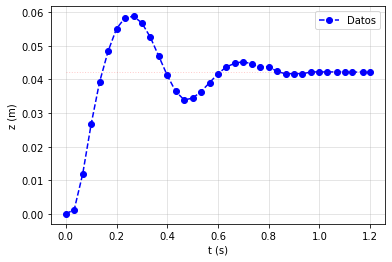

In [3]:
# Plot
plt.plot(time_data,height_data,'b--o',label='Datos')
plt.plot(time_data,[0.0423 for x in range(len(time_data))],'r:',alpha=0.2,linewidth=1)
plt.xlabel('t (s)')
plt.ylabel('z (m)')
plt.legend()
plt.grid(True,alpha=0.4)
plt.show()

In [4]:
def solver(time_axis,b):
    '''
    ABLE TO SOLVE A SECOND ORDER ODE FROM NEWTONIAN MODEL
    time_axis list. Time inverval
    n int. Number of steps
    h float. Dipped straw.
    b float. Idk.
    g float. Gravitational acceleration.
    
    OUTPUT (t,z)
    t list. Time.
    z list. Water's height through straw.
    '''
    # Interval time
    t0 = time_axis[0]#s
    tf = time_axis[-1]#s
    nsteps = 300
    dt = (tf - t0)/nsteps#s
    # Models param
    g = 9.81#m/s
    h = 0.045#m
    # Lists
    z = [0 for x in range(nsteps)]
    y = [0 for x in range(nsteps)]
    t = [0 for x in range(nsteps)]
    # Initial conditions
    z[0] = 0.0027#m
    y[0] = 0.0 #m
    t[0] = t0
    # Solve DE
    for i in range(nsteps-1):
        z[i+1] = z[i] + dt * y[i]
        y[i+1] = y[i] - dt * (y[i]**2 + g*z[i] -g*h +b*y[i])/z[i]
        t[i+1] = t[i] + dt
    return(t,z)

In [5]:
b = 0.265
t,z = solver(time_data,b)
z_eq = [0.0423 for x in range(len(time_data))]

In [6]:
def deviation(z,std_acc):
    z = np.array(z)
    return (z - 1 * std_acc,z + 1 * std_acc)

#std_acc = 0.001/2 #half of a mm
std_acc = 0.001
sigma_low,sigma_high = deviation(z,std_acc)

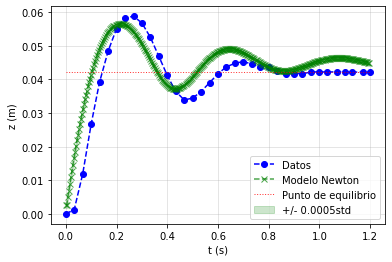

In [7]:
# Plot
plt.plot(time_data,height_data,'b--o',label='Datos')
plt.plot(t,z,'g--x',alpha=0.7,label='Modelo Newton')
plt.fill_between(t,sigma_low,sigma_high,color='g', alpha=0.2)
plt.plot(time_data,z_eq,'r:',alpha=0.8,linewidth=1)
plt.xlabel('t (s)')
plt.ylabel('z (m)')
plt.legend(('Datos','Modelo Newton','Punto de equilibrio','+/- 0.0005std'))
plt.grid(True,alpha=0.4)
plt.show()

In [8]:
print('z len:', len(z))
print('height_axis len:', len(height_data))

z len: 300
height_axis len: 37


In [9]:
# For interpolation
from __future__ import division, print_function

def print_list(values):
    print('[' + ', '.join(format(value, '.3f') for value in values) + ']')

def interpolate(inp, fi):
    i, f = int(fi // 1), fi % 1 # Split floating-point index into whole & fractional parts.
    j = i+1 if f > 0 else i  # Avoid index error.
    return (1-f) * inp[i] + f * inp[j]

def inter(z,data):
    new_len = len(z)
    delta = (len(data)-1) / (new_len-1)
    data_interpolated = [interpolate(data, i*delta) for i in range(new_len)]
    return data_interpolated

h_interpolated = inter(z,height_data)
print_list(height_data[:10])
print_list(h_interpolated[:10])

[0.000, 0.001, 0.012, 0.027, 0.039, 0.048, 0.055, 0.058, 0.059, 0.057]
[0.000, 0.000, 0.000, 0.000, 0.001, 0.001, 0.001, 0.001, 0.001, 0.002]


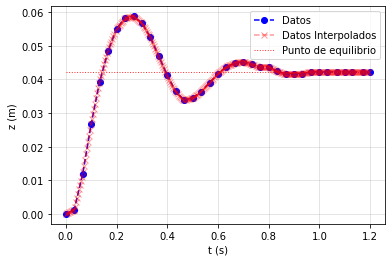

In [10]:
# Plot to verify the interpolation of the data
plt.plot(time_data,height_data,'b--o',label='Datos')
#plt.plot(t,z,'g--x',alpha=0.5,label='Modelo Newton')
plt.plot(t,h_interpolated,'r--x',alpha=0.4,label='Datos interpolados')
#plt.fill_between(t,sigma_low,sigma_high,color='g', alpha=0.2)
plt.plot(time_data,z_eq,'r:',alpha=0.8,linewidth=1)
plt.xlabel('t (s)')
plt.ylabel('z (m)')
plt.legend(('Datos','Datos Interpolados', 'Punto de equilibrio'))
plt.grid(True,alpha=0.4)
plt.show()

In [11]:
print('z len:', len(z))
print('height_axis len:', len(h_interpolated))

z len: 300
height_axis len: 300


In [24]:
# Find b optimum by brute force

B = np.linspace(0.1,1,500)
MSE = {}

for b in B:
    t,z = solver(time_data,b)
    h_interpolated = inter(z,height_data)
    z_arr = np.array(z)
    h_arr = np.array(h_interpolated)
    difference_array = np.subtract(h_arr, z_arr)
    squared_array = np.square(difference_array)
    mse = squared_array.mean()
    MSE[b] = mse
    
bopt = min(MSE,key=MSE.get)
mseopt = MSE[bopt]
print(f'Optimum value for b: {bopt}')
print(f'MSE for b optimum: {mseopt}')

Optimum value for b: 0.4480961923847695
MSE for b optimum: 2.987905367608432e-05


In [25]:
# Finally, run the Newtonian model for this value of b
topt,zopt = solver(time_data,bopt)
b = 0.265 #arbitrary
t,z = solver(time_data,b)
#std_acc = 0.001/2 #half of a mm
std_acc = 0.001 # a mm
std_accopt = mseopt + std_acc # a mm + mse
sigma_low,sigma_high = deviation(z,std_acc)
sigma_lowopt,sigma_highopt = deviation(zopt,std_accopt)

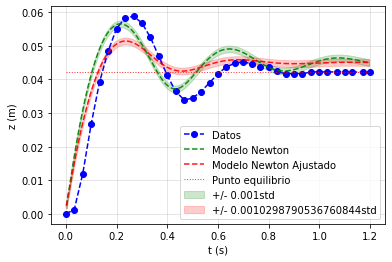

In [27]:
# And plot
plt.plot(time_data,height_data,'b--o',label='Datos')
plt.plot(t,z,'g--',alpha=0.9,label='Modelo Newton')
plt.fill_between(t,sigma_low,sigma_high,color='g', alpha=0.2)
plt.plot(topt,zopt,'r--',alpha=0.9,label='Modelo Newton Ajustado')
plt.fill_between(t,sigma_lowopt,sigma_highopt,color='r', alpha=0.2)
plt.plot(time_data,z_eq,'r:',alpha=0.8,linewidth=1)
plt.xlabel('t (s)')
plt.ylabel('z (m)')
plt.legend(('Datos','Modelo Newton','Modelo Newton Ajustado','Punto equilibrio','+/- 0.001std',f'+/- {std_accopt}std'))
plt.grid(True,alpha=0.4)
plt.show()